In [1]:
!pip install -qU av torch torchvision "transformers>=4.41.0" accelerate safetensors tokenizers sentencepiece
# restart session after installation

In [2]:
!nvidia-smi

Sat Jan 17 12:08:37 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:00:05.0 Off |                  Off |
| 30%   47C    P8             18W /  300W |       2MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import math
import json
import requests
import psutil
import gc
from typing import Optional, Tuple, Dict, List, Union, Any
from dataclasses import dataclass

import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from safetensors import safe_open
from safetensors.torch import load_file as load_safetensors

from huggingface_hub import hf_hub_download, snapshot_download

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16

MODEL_ID = "LanguageBind/Video-LLaVA-7B-hf"

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print(f"{torch.cuda.get_device_properties(0).total_memory / (1024 * 1024 * 1024)} GB")

NVIDIA RTX A6000
47.529052734375 GB


In [5]:
config_path = hf_hub_download(repo_id = MODEL_ID, filename = "config.json")
with open(config_path, "r") as f:
    full_config = json.load(f)

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

In [6]:
print(json.dumps(full_config, indent = 2))

{
  "architectures": [
    "VideoLlavaForConditionalGeneration"
  ],
  "ignore_index": -100,
  "image_token_index": 32000,
  "model_type": "video_llava",
  "pad_token_id": 32002,
  "projector_hidden_act": "gelu",
  "text_config": {
    "_name_or_path": "lmsys/vicuna-7b-v1.5",
    "architectures": [
      "LlamaForCausalLM"
    ],
    "max_position_embeddings": 4096,
    "model_type": "llama",
    "pad_token_id": 0,
    "rms_norm_eps": 1e-05,
    "torch_dtype": "float16",
    "vocab_size": 32064
  },
  "torch_dtype": "bfloat16",
  "transformers_version": "4.41.0.dev0",
  "video_token_index": 32001,
  "vision_config": {
    "hidden_size": 1024,
    "intermediate_size": 4096,
    "model_type": "clip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "patch_size": 14,
    "projection_dim": 768,
    "vocab_size": 32000
  },
  "vision_feature_layer": -2,
  "vision_feature_select_strategy": "default",
  "vocab_size": 32064
}


In [7]:
index_path = hf_hub_download(repo_id = MODEL_ID, filename = "model.safetensors.index.json")
with open(index_path, "r") as f:
    index = json.load(f)
all_keys = sorted(index["weight_map"].keys())
print(f"Total num keys : {len(all_keys)}\n")

top_level_cnts = {}
for k in all_keys:
    top_k = str(k).split(".")[0]
    top_level_cnts[top_k] = top_level_cnts.get(top_k, 0) + 1

for k, v in top_level_cnts.items():
    print(f"{k} : {v}")
print("\n" + "#" * 10 + "\n")

comps = {
    "language_model.model.embed_tokens": [],
    "language_model.model.layers.0": [],
    "language_model.model.layers.31": [],
    "language_model.model.norm": [],
    "language_model.lm_head": [],
    "image_tower": [],
    "video_tower": [],
    "multi_modal_projector": [],
}

for key in all_keys:
    for c in comps:
        if key.startswith(c) and len(comps[c]) < 5:
            comps[c].append(key)

for k, v in comps.items():
    print(f"{k} : {v}\n")

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Total num keys : 1077

image_tower : 391
language_model : 291
multi_modal_projector : 4
video_tower : 391

##########

language_model.model.embed_tokens : ['language_model.model.embed_tokens.weight']

language_model.model.layers.0 : ['language_model.model.layers.0.input_layernorm.weight', 'language_model.model.layers.0.mlp.down_proj.weight', 'language_model.model.layers.0.mlp.gate_proj.weight', 'language_model.model.layers.0.mlp.up_proj.weight', 'language_model.model.layers.0.post_attention_layernorm.weight']

language_model.model.layers.31 : ['language_model.model.layers.31.input_layernorm.weight', 'language_model.model.layers.31.mlp.down_proj.weight', 'language_model.model.layers.31.mlp.gate_proj.weight', 'language_model.model.layers.31.mlp.up_proj.weight', 'language_model.model.layers.31.post_attention_layernorm.weight']

language_model.model.norm : ['language_model.model.norm.weight']

language_model.lm_head : ['language_model.lm_head.weight']

image_tower : ['image_tower.vision_mo

In [8]:
@dataclass
class LlamaConfig:
    vocab_size : int = 32064
    hidden_size : int = 4096
    intermediate_size : int = 11008
    num_hidden_layers : int = 32
    num_attention_heads : int = 32
    num_key_value_heads : int = 32
    hidden_act : str = "silu"
    max_position_embeddings : int = 4096
    rms_norm_eps : float = 1e-5
    rope_theta : float = 10_000.0
    attention_bias : bool = False
    attention_dropout : float = 0.0
    
    @classmethod
    def from_dict(cls, config_dict : dict) -> "LlamaConfig":
        text_config = config_dict.get("text_config", config_dict)
        return cls(
            vocab_size = text_config.get("vocab_size", 32064),
            hidden_size = text_config.get("hidden_size", 4096),
            intermediate_size = text_config.get("intermediate_size", 11008),
            num_hidden_layers = text_config.get("num_hidden_layers", 32),
            num_attention_heads = text_config.get("num_attention_heads", 32),
            num_key_value_heads = text_config.get("num_key_value_heads", 32),
            hidden_act = text_config.get("hidden_act", "silu"),
            max_position_embeddings = text_config.get("max_position_embeddings", 4096),
            rms_norm_eps = text_config.get("rms_norm_eps", 1e-5),
            rope_theta = text_config.get("rope_theta", 10000.0),
            attention_bias = text_config.get("attention_bias", False),
            attention_dropout = text_config.get("attention_dropout", 0.0),
        )

In [9]:
@dataclass
class CLIPVisionConfig:
    hidden_size: int = 1024
    intermediate_size: int = 4096
    num_hidden_layers: int = 24
    num_attention_heads: int = 16
    image_size: int = 224
    patch_size: int = 14
    hidden_act: str = "quick_gelu"
    layer_norm_eps: float = 1e-5
    attention_dropout: float = 0.0
    num_channels: int = 3
    
    @classmethod
    def from_dict(cls, config_dict: dict) -> "CLIPVisionConfig":
        return cls(
            hidden_size = config_dict.get("hidden_size", 1024),
            intermediate_size = config_dict.get("intermediate_size", 4096),
            num_hidden_layers = config_dict.get("num_hidden_layers", 24),
            num_attention_heads = config_dict.get("num_attention_heads", 16),
            image_size = config_dict.get("image_size", 224),
            patch_size = config_dict.get("patch_size", 14),
            hidden_act = config_dict.get("hidden_act", "quick_gelu"),
            layer_norm_eps = config_dict.get("layer_norm_eps", 1e-5),
            attention_dropout = config_dict.get("attention_dropout", 0.0),
            num_channels = config_dict.get("num_channels", 3),
        )

In [10]:
@dataclass
class VideoLlavaConfig:
    text_config : LlamaConfig = None
    vision_config : CLIPVisionConfig = None
    video_config : CLIPVisionConfig = None
    ignore_index : int = -100
    image_token_index : int = 32000
    video_token_index : int = 32001
    projector_hidden_act : str = "gelu"
    vision_feature_select_strategy : str = "default"
    vision_feature_layer : int = -2
    
    @classmethod
    def from_dict(cls, config_dict: dict) -> "VideoLlavaConfig":
        return cls(
            text_config = LlamaConfig.from_dict(config_dict),
            vision_config = CLIPVisionConfig.from_dict(config_dict.get("vision_config", {})),
            video_config = CLIPVisionConfig.from_dict(config_dict.get("video_config", config_dict.get("vision_config", {}))),
            ignore_index = config_dict.get("ignore_index", -100),
            image_token_index = config_dict.get("image_token_index", 32000),
            video_token_index = config_dict.get("video_token_index", 32001),
            projector_hidden_act = config_dict.get("projector_hidden_act", "gelu"),
            vision_feature_select_strategy = config_dict.get("vision_feature_select_strategy", "default"),
            vision_feature_layer = config_dict.get("vision_feature_layer", -2),
        )

In [11]:
video_llava_config = VideoLlavaConfig.from_dict(full_config)
video_llava_config

VideoLlavaConfig(text_config=LlamaConfig(vocab_size=32064, hidden_size=4096, intermediate_size=11008, num_hidden_layers=32, num_attention_heads=32, num_key_value_heads=32, hidden_act='silu', max_position_embeddings=4096, rms_norm_eps=1e-05, rope_theta=10000.0, attention_bias=False, attention_dropout=0.0), vision_config=CLIPVisionConfig(hidden_size=1024, intermediate_size=4096, num_hidden_layers=24, num_attention_heads=16, image_size=224, patch_size=14, hidden_act='quick_gelu', layer_norm_eps=1e-05, attention_dropout=0.0, num_channels=3), video_config=CLIPVisionConfig(hidden_size=1024, intermediate_size=4096, num_hidden_layers=24, num_attention_heads=16, image_size=224, patch_size=14, hidden_act='quick_gelu', layer_norm_eps=1e-05, attention_dropout=0.0, num_channels=3), ignore_index=-100, image_token_index=32000, video_token_index=32001, projector_hidden_act='gelu', vision_feature_select_strategy='default', vision_feature_layer=-2)

In [12]:
def tiny_llama_config():
    return LlamaConfig(
        vocab_size = 32064,
        hidden_size = 256,
        intermediate_size = 1024,
        num_hidden_layers = 2,
        num_attention_heads = 4,
        num_key_value_heads = 4,
        max_position_embeddings = 256,
        rms_norm_eps = 1e-5,
        rope_theta = 10000.0,
        attention_bias = False,
        attention_dropout = 0.0
    )

In [13]:
def tiny_clip_config():
    return CLIPVisionConfig(
        hidden_size = 128,
        intermediate_size = 512,
        num_hidden_layers = 2,
        num_attention_heads = 4,
        image_size = 224,
        patch_size = 14,
        hidden_act = "quick_gelu",
        layer_norm_eps = 1e-5,
        attention_dropout = 0.0,
        num_channels = 3
    )

In [14]:
def tiny_video_llava_config():
    return VideoLlavaConfig(
        text_config = tiny_llama_config(),
        vision_config = tiny_clip_config(),
        video_config = tiny_clip_config(),
        image_token_index = 32000,
        video_token_index = 32001,
        projector_hidden_act = "gelu",
        vision_feature_select_strategy = "default",
        vision_feature_layer = -2,
    )

In [15]:
class LlamaRMSNorm(nn.Module):
    def __init__(self, hidden_size : int, eps : float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps
    
    def forward(self, hidden_tensor : torch.Tensor) -> torch.Tensor:
        input_dtype = hidden_tensor.dtype
        hidden_tensor = hidden_tensor.to(torch.float32)
        variance = hidden_tensor.pow(2).mean(dim = -1, keepdim = True)
        hidden_tensor = hidden_tensor * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_tensor.to(input_dtype)

In [16]:
test_config = tiny_llama_config()
test_vision_config = tiny_clip_config()

In [17]:
test_rms_norm = LlamaRMSNorm(hidden_size = test_config.hidden_size, eps = test_config.rms_norm_eps)
test_input = torch.randn([2, 10, test_config.hidden_size], dtype = DTYPE)
out = test_rms_norm(test_input)
print(out.shape)
print(test_rms_norm.weight.shape)

torch.Size([2, 10, 256])
torch.Size([256])


In [18]:
class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, 
                 dim : int, 
                 max_position_embeddings : int = 4096, 
                 base : float = 10000.0, 
                 device : Optional[torch.device] = None):
        super().__init__()
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        
        inv_freq = 1 / (self.base ** (torch.arange(0, self.dim, 2, dtype = torch.float32) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent = False)
        self._set_cos_sin_cache(max_position_embeddings, device = device, dtype = torch.float32)
    
    def _set_cos_sin_cache(self, seq_len : int, device : Optional[torch.device] = None, dtype : torch.dtype = torch.float32):
        self.max_seq_len_cached = seq_len
        t = torch.arange(seq_len, device = device, dtype = dtype)
        freq = torch.outer(t, self.inv_freq.to(device))  # [seq_len, embed_dim // 2]
        embed = torch.cat([freq, freq], dim = -1) # [seq_len, embed_dim]
        self.register_buffer("cos_cached", embed.cos().to(dtype), persistent = False)
        self.register_buffer("sin_cached", embed.sin().to(dtype), persistent = False)
    
    def forward(self, x : torch.Tensor, position_ids : torch.Tensor):
        seq_len = int(position_ids.max().item()) + 1
        if seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len, x.device, torch.float32)
        cos = self.cos_cached[position_ids].to(x.dtype)
        sin = self.sin_cached[position_ids].to(x.dtype)
        return cos, sin

In [19]:
def rotate_half(x : torch.Tensor):
    x_1 = x[..., : x.shape[-1] // 2]
    x_2 = x[..., x.shape[-1] // 2 :]
    return torch.cat([-x_2, x_1], dim = -1)

In [20]:
def apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim : int = 1):
    # q : [batch_size, num_heads, seq_len, head_dim]
    # cos : [batch_size, seq_len, head_dim]
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

torch.Size([1, 500, 256]) torch.Size([1, 500, 256])
torch.Size([1, 1, 500, 256])
torch.Size([500, 256])


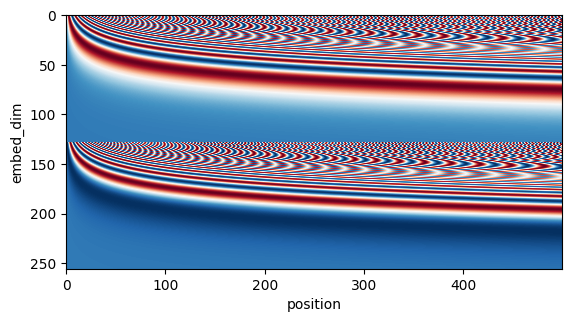

In [21]:
# test_num_attn_heads = test_config.num_attention_heads
test_num_attn_heads = 1
test_head_dim = test_config.hidden_size // test_num_attn_heads
test_rot_emb = LlamaRotaryEmbedding(test_head_dim, test_config.max_position_embeddings, device = "cpu")

test_pos_ids = torch.arange(500, dtype = torch.int64).unsqueeze(0)
q = torch.ones([1, test_num_attn_heads, 500, test_head_dim])
k = torch.ones([1, test_num_attn_heads, 500, test_head_dim])

cos, sin = test_rot_emb(q, test_pos_ids)
print(cos.shape, sin.shape)

q_embed, k_embed = apply_rotary_pos_emb(q, k, cos, sin)
print(q_embed.shape)
q_embed = q_embed.permute([0, 2, 1, 3]).contiguous()
q_embed = q_embed.view((q_embed.shape[0], q_embed.shape[1], -1)).squeeze()
print(q_embed.shape)


plt.imshow(q_embed.T, cmap = "RdBu")
plt.xlabel("position")
plt.ylabel("embed_dim")
plt.show()

In [22]:
class LlamaAttention(nn.Module):
    def __init__(self, config : LlamaConfig, layer_idx : int):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = config.num_attention_heads // self.num_key_value_heads
        self.attention_dropout = config.attention_dropout
        
        if self.hidden_size % self.num_heads != 0:
            raise ValueError(f"hidden_size {self.hidden_size} must be divisible by num_heads {self.num_heads}")
        
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias = config.attention_bias)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias = config.attention_bias)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias = config.attention_bias)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias = config.attention_bias)
        
        self.rotary_emb = LlamaRotaryEmbedding(self.head_dim, config.max_position_embeddings, base = config.rope_theta)
    
    def forward(self,
               hidden_states : torch.Tensor,
               attention_mask : Optional[torch.Tensor] = None,
               position_ids : Optional[torch.Tensor] = None,
               past_key_value : Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
               output_attentions : bool = False,
               use_cache : bool = False):
        
        batch_size, seq_len, _ = hidden_states.shape
        
        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)
        
        query_states = query_states.reshape([batch_size, seq_len, self.num_heads, self.head_dim]).transpose(1, 2)
        key_states = key_states.reshape([batch_size, seq_len, self.num_key_value_heads, self.head_dim]).transpose(1, 2)
        value_states = value_states.reshape([batch_size, seq_len, self.num_key_value_heads, self.head_dim]).transpose(1, 2)
        
        cos, sin = self.rotary_emb(query_states, position_ids)
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)
        
        
        if past_key_value is not None:
            past_key, past_value = past_key_value
            key_states = torch.cat([past_key, key_states], dim = 2)
            value_states = torch.cat([past_value, value_states], dim = 2)
        
        past_key_value = (key_states, value_states) if use_cache else None
        
        key_states = self._repeat_kv(key_states, self.num_key_value_groups)
        value_states = self._repeat_kv(value_states, self.num_key_value_groups)
        
        attn_weights = torch.matmul(query_states, key_states.transpose(-1, -2)) / math.sqrt(self.head_dim)
        if attention_mask is not None:
            attn_weights = attn_weights + attention_mask
        attn_weights = F.softmax(attn_weights, dim = -1, dtype = torch.float32).to(query_states.dtype)
        attn_output = torch.matmul(attn_weights, value_states)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape([batch_size, seq_len, self.hidden_size])
        attn_output = self.o_proj(attn_output)
        
        if not output_attentions:
            attn_weights = None
        
        return attn_output, attn_weights, past_key_value
    
    def _repeat_kv(self, hidden_states : torch.Tensor, n_rep : int):
        # hidden_states : [batch_size, num_kv_heads, seq_len, head_dim]
        if n_rep == 1:
            return hidden_states
        
        batch_size, num_kv_heads, seq_len, head_dim = hidden_states.shape
        hidden_states = hidden_states[:, :, None, :, :].expand(batch_size, num_kv_heads, n_rep, seq_len, head_dim)
        return hidden_states.reshape([batch_size, num_kv_heads * n_rep, seq_len, head_dim])

In [23]:
class LlamaMLP(nn.Module):
    def __init__(self, config : LlamaConfig):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias = False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias = False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias = False)
        
        self.act_fn = nn.SiLU()
    
    
    def forward(self, x : torch.Tensor):
        gate_output = self.act_fn(self.gate_proj(x))
        up_output = self.up_proj(x)
        return self.down_proj(gate_output * up_output)

In [24]:
x = torch.randn([2, 10, test_config.hidden_size])

test_llama_attn = LlamaAttention(test_config, layer_idx = 0)
test_pos = torch.arange(10).unsqueeze(0).expand(2, -1)
test_mask = torch.triu(torch.full((10, 10), -float("inf")), diagonal = 1).unsqueeze(0).unsqueeze(0)
test_attn_output, _, _ = test_llama_attn(x, attention_mask = test_mask, position_ids = test_pos)
print(test_attn_output.shape)

test_mlp = LlamaMLP(test_config)
print(test_mlp(x).shape)

torch.Size([2, 10, 256])
torch.Size([2, 10, 256])


In [25]:
class LlamaDecoderLayer(nn.Module):
    def __init__(self, config : LlamaConfig, layer_idx : int):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.self_attn = LlamaAttention(config, layer_idx)
        self.mlp = LlamaMLP(config)
        self.input_layernorm = LlamaRMSNorm(config.hidden_size, eps = config.rms_norm_eps)
        self.post_attention_layernorm = LlamaRMSNorm(config.hidden_size, eps = config.rms_norm_eps)
    
    def forward(self,
               hidden_states : torch.Tensor,
               attention_mask : Optional[torch.Tensor] = None,
               position_ids : Optional[torch.Tensor] = None,
               past_key_value : Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
               output_attentions : bool = False,
               use_cache : bool = False):
        
        res = hidden_states
        hidden_states = self.input_layernorm(hidden_states)
        hidden_states, attn_weights, present_key_value = self.self_attn(hidden_states,
                                                                       attention_mask,
                                                                       position_ids,
                                                                       past_key_value,
                                                                       output_attentions,
                                                                       use_cache)
        hidden_states = hidden_states + res
        
        res = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = hidden_states + res
        
        outputs = (hidden_states, )
        
        if output_attentions:
            outputs += (attn_weights, )
        
        if use_cache:
            outputs += (present_key_value, )
        
        return outputs

In [26]:
test_layer = LlamaDecoderLayer(test_config, layer_idx = 0)
test_hidden = torch.randn(2, 10, test_config.hidden_size)
layer_out = test_layer(test_hidden, position_ids = test_pos, attention_mask = test_mask)
print(len(layer_out))
print(layer_out[0].shape)

1
torch.Size([2, 10, 256])


In [27]:
def _prepare_4d_causal_mask_attention(attention_mask_2d : torch.Tensor,
                                     q_len : int,
                                     past_len : int,
                                     dtype : torch.dtype,
                                     device : torch.device):
    b = attention_mask_2d.size(0)
    total_kv_len = q_len + past_len
    MIN_VAL = torch.finfo(torch.float32).min
    
    if attention_mask_2d.size(1) < total_kv_len:
        pad_len = total_kv_len - attention_mask_2d.size(1)
        attention_mask_2d = F.pad(attention_mask_2d, (0, pad_len), value = 1)
    elif attention_mask_2d.size(1) > total_kv_len:
        attention_mask_2d = attention_mask_2d[:, : total_kv_len]
    
    causal = torch.zeros((q_len, total_kv_len), device = device, dtype = torch.float32)
    causal = torch.triu(torch.full_like(causal, MIN_VAL), diagonal = past_len + 1)
    causal = causal[None, None, :, :].expand(b, 1, q_len, total_kv_len)
    
    key_pad_mask = (attention_mask_2d == 0)[:, None, None, :].expand(b, 1, q_len, total_kv_len)
    causal = causal.masked_fill(key_pad_mask, MIN_VAL)
    
    return causal.to(dtype)

In [28]:
class LlamaModel(nn.Module):
    def __init__(self, config : LlamaConfig):
        super().__init__()
        self.config = config
        self.vocab_size = config.vocab_size
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config, layer_idx = i) for i in range(config.num_hidden_layers)])
        self.norm = LlamaRMSNorm(config.hidden_size, config.rms_norm_eps)
    
    def forward(self,
               input_ids : Optional[torch.LongTensor] = None,
               attention_mask : Optional[torch.Tensor] = None,
               position_ids: Optional[torch.LongTensor] = None,
               past_key_values: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None,
               input_embeds : Optional[torch.FloatTensor] = None,
               use_cache: bool = False,
               output_attentions: bool = False,
               output_hidden_states: bool = False):
        
        if input_embeds is None:
            input_embeds = self.embed_tokens(input_ids)
        
        batch_size, seq_length = input_embeds.shape[: 2]
        past_length = 0
        if past_key_values is not None and len(past_key_values) > 0:
            past_length = past_key_values[0][0].shape[2]
        
        if position_ids is None:
            position_ids = torch.arange(past_length, past_length + seq_length, 
                                        dtype = torch.long, 
                                        device = input_embeds.device).unsqueeze(0)
        
        if attention_mask is None:
            attention_mask = self._create_causal_mask(batch_size, seq_length, past_length, input_embeds.dtype, input_embeds.device)
        elif attention_mask.dim() == 2:
            attention_mask = _prepare_4d_causal_mask_attention(attention_mask, 
                                                               seq_length, 
                                                               past_length, 
                                                               input_embeds.dtype, 
                                                               input_embeds.device)
        elif attention_mask.dim() == 4:
            pass
        else:
            raise ValueError(f"Attention Mask must be either 2D or 4D, but current attention_mask is {attention_mask.dim()} D")
        
        hidden_states = input_embeds
        
        all_hidden_states = [] if output_hidden_states else None
        all_attentions = [] if output_attentions else None
        next_cache = [] if use_cache else None
        
        for idx, layer in enumerate(self.layers):
            if output_hidden_states:
                all_hidden_states.append(hidden_states)
            past_kv = past_key_values[idx] if past_key_values else None
            layer_outputs = layer(hidden_states, attention_mask, position_ids, past_kv, output_attentions, use_cache)
            
            hidden_states = layer_outputs[0]
            if output_attentions:
                all_attentions.append(layer_outputs[1])
            if use_cache:
                next_cache.append(layer_outputs[-1])
            
        hidden_states = self.norm(hidden_states)
        if output_hidden_states:
            all_hidden_states.append(hidden_states)
        
        return tuple(v for v in [hidden_states, next_cache, all_hidden_states, all_attentions] if v is not None)
    
    def _create_causal_mask(self, 
                            batch_size : int, 
                            seq_length : int, 
                            past_length : int, 
                            dtype : torch.dtype, 
                            device : torch.device):
        total_length = past_length + seq_length
        MIN_VAL = torch.finfo(torch.float32).min
        mask = torch.triu(
            torch.full((seq_length, total_length), MIN_VAL, dtype = torch.float32, device = device),
            diagonal = past_length + 1
        )
        return mask.unsqueeze(0).unsqueeze(0).expand(batch_size, 1, -1, -1).to(dtype)

In [29]:
print(test_config, end = "\n\n")
print(f"{psutil.virtual_memory().percent} percent used, Available : {psutil.virtual_memory().available / 1e9} GB")
test_llama_model = LlamaModel(test_config)
print(f"{psutil.virtual_memory().percent} percent used, Available : {psutil.virtual_memory().available / 1e9} GB")
test_ids = torch.randint(0, 32000, (2, 10))
model_out = test_llama_model(input_ids=test_ids)
print(f"Input IDs shape: {test_ids.shape}")
print(f"Output shape: {model_out[0].shape}")
print(f"embed_tokens: {test_llama_model.embed_tokens.weight.shape}")
print(f"Number of layers: {len(test_llama_model.layers)}")
print(f"Final norm: {test_llama_model.norm.weight.shape}")

del test_llama_model

LlamaConfig(vocab_size=32064, hidden_size=256, intermediate_size=1024, num_hidden_layers=2, num_attention_heads=4, num_key_value_heads=4, hidden_act='silu', max_position_embeddings=256, rms_norm_eps=1e-05, rope_theta=10000.0, attention_bias=False, attention_dropout=0.0)

7.9 percent used, Available : 43.609042944 GB
8.0 percent used, Available : 43.5659776 GB
Input IDs shape: torch.Size([2, 10])
Output shape: torch.Size([2, 10, 256])
embed_tokens: torch.Size([32064, 256])
Number of layers: 2
Final norm: torch.Size([256])


In [30]:
class LlamaForCausalLM(nn.Module):
    # add lm head to it.
    def __init__(self, config : LlamaConfig):
        super().__init__()
        self.config = config
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias = False)
    
    def forward(self,
                input_ids: Optional[torch.LongTensor] = None,
                attention_mask: Optional[torch.Tensor] = None,
                position_ids: Optional[torch.LongTensor] = None,
                past_key_values: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None,
                input_embeds: Optional[torch.FloatTensor] = None,
                labels: Optional[torch.LongTensor] = None,
                use_cache: bool = False,
                output_attentions: bool = False,
                output_hidden_states: bool = False):
        outputs = self.model(input_ids, 
                             attention_mask, 
                             position_ids, 
                             past_key_values, 
                             input_embeds, 
                             use_cache)
        hidden_states = outputs[0]
        logits = self.lm_head(hidden_states)
        
        loss = None
        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:, :].contiguous()
            loss = F.cross_entropy(shift_logits.view(-1, config.vocab_size), shift_labels.view(-1))
        return (logits, loss) + outputs[1: ]

In [31]:
print(f"{psutil.virtual_memory().percent} percent used, Available : {psutil.virtual_memory().available / 1e9} GB")
test_causal_lm = LlamaForCausalLM(test_config)
print(f"{psutil.virtual_memory().percent} percent used, Available : {psutil.virtual_memory().available / 1e9} GB")
test_ids = torch.randint(0, 32000, (2, 10))
lm_out = test_causal_lm(input_ids = test_ids)
print(f"Input IDs shape: {test_ids.shape}")
print(f"Logits shape: {lm_out[0].shape}")
print(f"lm_head weight: {test_causal_lm.lm_head.weight.shape}")

del test_causal_lm
gc.collect()
print()

8.0 percent used, Available : 43.560103936 GB
8.1 percent used, Available : 43.501367296 GB
Input IDs shape: torch.Size([2, 10])
Logits shape: torch.Size([2, 10, 32064])
lm_head weight: torch.Size([32064, 256])



In [32]:
class CLIPVisionEmbeddings(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches + 1
        self.class_embedding = nn.Parameter(torch.randn(self.embed_dim)) # cls token
        self.patch_embedding = nn.Conv2d(in_channels = config.num_channels, 
                                         out_channels = self.embed_dim, 
                                         kernel_size = config.patch_size, 
                                         stride = config.patch_size, 
                                         bias = False)
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer("position_ids", torch.arange(self.num_positions).expand(1, -1), persistent = False)
    
    def forward(self, pixel_values : torch.Tensor) -> torch.Tensor:
        # pixel_values : [batch_size, channel, height, width]
        batch_size = pixel_values.shape[0]
        pixel_embeds = self.patch_embedding(pixel_values).flatten(2)
        pixel_embeds = pixel_embeds.transpose(1, 2) # [batch_size, num_patches, embed_dim]
        class_embeds = self.class_embedding.expand(batch_size, 1, -1)
        embeddings = torch.concat([class_embeds, pixel_embeds], dim = 1) + self.position_embedding(self.position_ids)
        return embeddings

In [33]:
test_vision_config = tiny_clip_config()
test_embed = CLIPVisionEmbeddings(test_vision_config)
test_img = torch.randn([2, 3, test_vision_config.image_size, test_vision_config.image_size])
test_embed(test_img).shape

torch.Size([2, 257, 128])

In [34]:
class CLIPAttention(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim ** -0.5
        self.dropout = config.attention_dropout
        
        # here bias = True [default]
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)
    
    def forward(self, 
                hidden_states : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None, 
                causal_attention_mask : Optional[torch.Tensor] = None, 
                output_attentions : bool = False):
        
        batch_size, seq_len, _ = hidden_states.shape
        query = self.q_proj(hidden_states)
        key = self.k_proj(hidden_states)
        value = self.v_proj(hidden_states)
        
        query = query.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        attn_weights = torch.matmul(query, key.transpose(-2, -1)) * self.scale
        if causal_attention_mask is not None:
            attn_weights += casual_attention_mask
        if attention_mask is not None:
            attn_weights += attention_mask
        
        attn_weights = F.softmax(attn_weights, dim = -1, dtype = torch.float32).to(hidden_states.dtype)
        attn_weights = F.dropout(attn_weights, p = self.dropout, training = self.training)
        
        attn_output = torch.matmul(attn_weights, value)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
        attn_output = self.out_proj(attn_output)
        
        return attn_output, attn_weights if output_attentions else None

In [35]:
test_vision_attn = CLIPAttention(test_vision_config)
num_positions = (test_vision_config.image_size // test_vision_config.patch_size) ** 2 + 1
test_inp_attn = torch.randn([2, num_positions, test_vision_config.hidden_size])
test_attn_out, _ = test_vision_attn(test_inp_attn)
print(test_attn_out.shape)
print(test_vision_attn.q_proj.weight.shape, test_vision_attn.q_proj.bias.shape)

torch.Size([2, 257, 128])
torch.Size([128, 128]) torch.Size([128])


In [36]:
def quick_gelu(x : torch.Tensor):
    return x * torch.sigmoid(1.702 * x)

In [37]:
 class CLIPMLP(nn.Module):
        def __init__(self, config : CLIPVisionConfig):
            super().__init__()
            self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
            self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
            self.activation_fn = quick_gelu if config.hidden_act == "quick_gelu" else F.gelu
        
        def forward(self, hidden_states : torch.Tensor):
            hidden_states = self.fc1(hidden_states)
            hidden_states = self.activation_fn(hidden_states)
            hidden_states = self.fc2(hidden_states)
            return hidden_states

In [38]:
test_mlp = CLIPMLP(test_vision_config)
test_mlp_out = test_mlp(test_inp_attn)
test_mlp_out.shape

torch.Size([2, 257, 128])

In [39]:
class CLIPEncoderLayer(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = CLIPAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps = config.layer_norm_eps)
        self.mlp = CLIPMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps = config.layer_norm_eps)
    
    def forward(self, 
                hidden_states : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None, 
                causal_attention_mask : Optional[torch.Tensor] = None, 
                output_attentions : bool = False):
        
        residual = hidden_states
        hidden_states = self.layer_norm1(hidden_states)
        hidden_states, attn_weights = self.self_attn(hidden_states, attention_mask, causal_attention_mask, output_attentions)
        hidden_states += residual
        
        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states += residual
        
        return hidden_states, attn_weights

In [40]:
test_clip_enc_layer = CLIPEncoderLayer(test_vision_config)
test_clip_lay_out, _ = test_clip_enc_layer(test_inp_attn)
print(test_clip_lay_out.shape)

torch.Size([2, 257, 128])


In [41]:
class CLIPEncoder(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([CLIPEncoderLayer(config) for _ in range(config.num_hidden_layers)])
    
    def forward(self, 
                input_embeds : torch.Tensor, 
                attenion_mask : Optional[torch.Tensor] = None, 
                causal_attention_mask : Optional[torch.Tensor] = None, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        
        all_attentions = [] if output_attentions else None
        all_hidden_states = [] if output_hidden_states else None
        hidden_states = input_embeds
        
        for layer in self.layers:
            if output_hidden_states:
                all_hidden_states.append(hidden_states)
            hidden_states, attn_weights = layer(hidden_states, attenion_mask, causal_attention_mask, output_attentions)
            
            if output_attentions:
                all_attentions.append(attn_weights)
        
        if output_hidden_states:
            all_hidden_states.append(hidden_states)
        
        return tuple(v for v in [hidden_states, all_hidden_states, all_attentions] if v is not None)

In [42]:
test_enc = CLIPEncoder(test_vision_config)
test_enc_out = test_enc(test_inp_attn)
test_enc_out[0].shape

torch.Size([2, 257, 128])

In [43]:
class CLIPVisionTransformer(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = CLIPVisionEmbeddings(config)
        self.pre_layrnorm = nn.LayerNorm(config.hidden_size, eps = config.layer_norm_eps)
        self.encoder = CLIPEncoder(config)
        self.post_layernorm = nn.LayerNorm(config.hidden_size, eps = config.layer_norm_eps)
    
    def forward(self, 
                pixel_values : torch.Tensor, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        
        hidden_states = self.embeddings(pixel_values)
        hidden_states = self.pre_layrnorm(hidden_states)
        encoder_outputs = self.encoder(input_embeds = hidden_states, 
                                       output_attentions = output_attentions, 
                                       output_hidden_states = output_hidden_states)
        
        last_hidden_state = encoder_outputs[0]
        pooled_output = last_hidden_state[:, 0, :] # CLS token
        pooled_output = self.post_layernorm(pooled_output)
        
        return (last_hidden_state, pooled_output) + encoder_outputs[1: ]

In [44]:
test_vit = CLIPVisionTransformer(test_vision_config)
vit_output = test_vit(test_img)
vit_output[0].shape, vit_output[1].shape

(torch.Size([2, 257, 128]), torch.Size([2, 128]))

In [45]:
class CLIPVisionModel(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.vision_model = CLIPVisionTransformer(config)
    
    def forward(self, 
                pixel_values : torch.Tensor, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        
        return self.vision_model(pixel_values, output_attentions, output_hidden_states)

In [46]:
test_vision_model = CLIPVisionModel(test_vision_config)
out_vis = test_vision_model(test_img)
out_vis[0].shape, out_vis[1].shape

(torch.Size([2, 257, 128]), torch.Size([2, 128]))

In [47]:
class VideoLlavaMultiModalProjector(nn.Module):
    def __init__(self, vision_hidden_size : int, text_hidden_size : int):
        super().__init__()
        self.linear_1 = nn.Linear(vision_hidden_size, text_hidden_size, bias = True)
        self.linear_2 = nn.Linear(text_hidden_size, text_hidden_size, bias = True)
        self.act = nn.GELU()
    
    def forward(self, image_features : torch.Tensor):
        hidden = self.linear_1(image_features)
        hidden = self.act(hidden)
        hidden = self.linear_2(hidden)
        return hidden

In [48]:
test_proj = VideoLlavaMultiModalProjector(test_vision_config.hidden_size, test_config.hidden_size)
num_patches = (test_vision_config.image_size // test_vision_config.patch_size) ** 2 + 1
test_img_f = torch.randn([2, num_patches, test_vision_config.hidden_size])
print(test_proj(test_img_f).shape)

torch.Size([2, 257, 256])


In [49]:
class VideoLlavaForConditionalGeneration(nn.Module):
    # image_tower, video_tower, multi_model_proj, llama_model
    def __init__(self, config : VideoLlavaConfig):
        super().__init__()
        self.config = config
        self.image_tower = CLIPVisionModel(config.vision_config)
        self.video_tower = CLIPVisionModel(config.video_config)
        self.multi_modal_projector = VideoLlavaMultiModalProjector(config.vision_config.hidden_size, 
                                                                   config.text_config.hidden_size)
        self.language_model = LlamaForCausalLM(config.text_config)
        self.image_token_index = config.image_token_index
        self.video_token_index = config.video_token_index
        self.vision_feature_layer = config.vision_feature_layer
        self.vision_feature_select_strategy = config.vision_feature_select_strategy
    
    def _get_vision_features(self, 
                             pixel_values : torch.Tensor, 
                             tower : CLIPVisionModel):
        
        outputs = tower(pixel_values, output_hidden_states = True)
        if len(outputs) > 2 and outputs[2] is not None:
            features = outputs[2][self.config.vision_feature_layer]
        else:
            features = outputs[0]
        
        if self.config.vision_feature_select_strategy == "default":
            features = features[:, 1 :]
        
        return features
    
    
    def _merge_vision_text(self, 
                           vision_features : torch.Tensor, 
                           input_embeds : torch.Tensor, 
                           input_ids : torch.Tensor, 
                           attention_mask : torch.Tensor, 
                           special_token_id : int):
        
        batch_size, seq_len = input_ids.shape
        num_vision_tokens = vision_features.shape[1]
        new_embeds = []
        new_masks = []
        
        
        for b in range(batch_size):
            positions = (input_ids[b] == special_token_id).nonzero(as_tuple = True)[0]
            if len(positions) == 0:
                new_embeds.append(input_embeds[b])
                new_masks.append(attention_mask[b])
                continue
            
            first_pos = positions[0].item()
            last_pos = positions[-1].item()
            num_placeholders = len(positions)
            
            if last_pos - first_pos + 1 != num_placeholders:
                print(f"Non-Consecutive special tokens {special_token_id} found. Using simple replacement.")
                last_pos = first_pos
                num_placeholders = 1
            
            v_idx = min(b, vision_features.shape[0] - 1)
            v_feat = vision_features[v_idx]
            
            before = input_embeds[b, : first_pos]
            after = input_embeds[b, last_pos + 1 :]
            merged = torch.cat([before, v_feat, after], dim = 0)
            
            before_m = attention_mask[b, : first_pos]
            after_m = attention_mask[b, last_pos + 1 :]
            vision_m = torch.ones(num_vision_tokens, dtype = attention_mask.dtype, device = attention_mask.device)
            merged_m = torch.cat([before_m, vision_m, after_m], dim = 0)
            
            new_embeds.append(merged)
            new_masks.append(merged_m)
        
        max_len = max(e.shape[0] for e in new_embeds)
        padded_embeds = []
        padded_masks = []
        
        for e, m in zip(new_embeds, new_masks):
            pad_len = max_len - e.shape[0]
            if pad_len > 0:
                e = F.pad(e, (0, 0, 0, pad_len))
                m = F.pad(m, (0, pad_len))
            padded_embeds.append(e)
            padded_masks.append(m)
        
        embeds = torch.stack(padded_embeds)
        masks = torch.stack(padded_masks)
        pos_ids = torch.arange(max_len, device = input_ids.device).unsqueeze(0).expand(batch_size, -1)
        return embeds, masks, pos_ids
    
    def forward(self, 
                input_ids : torch.LongTensor = None,
                pixel_values_images : Optional[torch.FloatTensor] = None,
                pixel_values_videos : Optional[torch.FloatTensor] = None,
                attention_mask : Optional[torch.Tensor] = None,
                position_ids : Optional[torch.LongTensor] = None,
                past_key_values : Optional[List[torch.FloatTensor]] = None,
                input_embeds : Optional[torch.FloatTensor] = None,
                labels : Optional[torch.LongTensor] = None,
                use_cache : Optional[bool] = None,
                output_attentions : Optional[bool] = None,
                output_hidden_states : Optional[bool] = None):
        
        if input_embeds is None:
            input_embeds = self.language_model.model.embed_tokens(input_ids)
        
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        
        if pixel_values_images is not None:
            image_features = self._get_vision_features(pixel_values_images, self.image_tower)
            image_features = self.multi_modal_projector(image_features)
            input_embeds, attention_mask, position_ids = self._merge_vision_text(image_features, 
                                                                                 input_embeds, 
                                                                                 input_ids, 
                                                                                 attention_mask, 
                                                                                 self.image_token_index)
            
        if pixel_values_videos is not None:
            batch_size, num_frames, c, h, w = pixel_values_videos.shape
            frames = pixel_values_videos.view(batch_size * num_frames, c, h, w)
            frame_features = self._get_vision_features(frames, self.video_tower) # [batch_size * num_frames, num_p, dim]
            num_patches = frame_features.shape[1]
            hidden_size = frame_features.shape[2]
            frame_features = frame_features.view(batch_size, num_frames, num_patches, hidden_size)

            num_placeholders = (input_ids == self.video_token_index).sum(dim = 1).max().item()
            if num_placeholders > num_patches:
                video_features = frame_features.reshape(batch_size, num_frames * num_patches, hidden_size)
            else:
                video_features = frame_features.mean(dim = 1)

            video_features = self.multi_modal_projector(video_features)
            input_embeds, attention_mask, position_ids = self._merge_vision_text(video_features, 
                                                                                 input_embeds, 
                                                                                 input_ids, 
                                                                                 attention_mask, 
                                                                                 self.video_token_index)
        
        outputs = self.language_model(input_ids = None,
                                      attention_mask = attention_mask,
                                      position_ids = position_ids,
                                      past_key_values = past_key_values,
                                      input_embeds = input_embeds,
                                      labels = labels,
                                      use_cache = use_cache,
                                      output_attentions = output_attentions,
                                      output_hidden_states = output_hidden_states)
        return outputs
    
    @torch.no_grad()
    def generate(self,
                 input_ids : torch.LongTensor,
                 pixel_values_images : Optional[torch.FloatTensor] = None,
                 pixel_values_videos : Optional[torch.FloatTensor] = None,
                 attention_mask : Optional[torch.Tensor] = None,
                 max_new_tokens : int = 256,
                 do_sample : bool = False,
                 temperature : float = 1.0,
                 **kwargs):
        
        outputs = self.forward(input_ids = input_ids,
                               pixel_values_images = pixel_values_images,
                               pixel_values_videos = pixel_values_videos,
                               attention_mask = attention_mask,
                               use_cache = True)
        
        logits = outputs[0]
        past_key_values = outputs[2] if len(outputs) > 0 else None
        next_logits = logits[:, -1, :]
        if do_sample:
            next_logits = next_logits / temperature
            probs = F.softmax(next_logits, dim = -1)
            next_token = torch.multinomial(probs, num_samples = 1)
        else:
            next_token = next_logits.argmax(dim = -1, keepdim = True)
        
        generated = [next_token]
        
        for _ in range(max_new_tokens - 1):
            outputs = self.language_model(input_ids = next_token,
                                          past_key_values = past_key_values,
                                          use_cache = True)
            
            logits = outputs[0]
            past_key_values = outputs[2] if len(outputs) > 0 else None
            next_logits = logits[:, -1, :]
            if do_sample:
                next_logits = next_logits / temperature
                probs = F.softmax(next_logits, dim = -1)
                next_token = torch.multinomial(probs, num_samples = 1)
            else:
                next_token = next_logits.argmax(dim = -1, keepdim = True)
            
            generated.append(next_token)
            
            if (next_token == 2).all():
                break
        
        generated = torch.cat(generated, dim = -1)
        return torch.cat([input_ids, generated], dim = -1)

In [50]:
test_tiny = VideoLlavaForConditionalGeneration(tiny_video_llava_config())
for name, _ in test_tiny.named_children():
    print(f"{name}")

image_tower
video_tower
multi_modal_projector
language_model


In [51]:
model_dir = snapshot_download(repo_id = MODEL_ID, 
                              cache_dir="./model_cache", 
                              allow_patterns=["*.safetensors", "*.json"])

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

In [52]:
safetensor_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".safetensors")])
print(f"Found {len(safetensor_files)} files.")

for f in safetensor_files:
    size_mb = os.path.getsize(os.path.join(model_dir, f)) / (1024 ** 2)
    print(f"{f} : {size_mb:.1f} MB")

Found 3 files.
model-00001-of-00003.safetensors : 4749.3 MB
model-00002-of-00003.safetensors : 4718.2 MB
model-00003-of-00003.safetensors : 4582.7 MB


In [53]:
print(f"{psutil.virtual_memory().percent} % used from {(psutil.virtual_memory().total / 1e9):.2f} GB")
with torch.device("meta"):
    model = VideoLlavaForConditionalGeneration(video_llava_config)
print(f"{psutil.virtual_memory().percent} % used from {(psutil.virtual_memory().total / 1e9):.2f} GB")

8.4 % used from 47.33 GB
8.5 % used from 47.33 GB


In [54]:
COMPUTED_BUFFERS = {"inv_freq", "cos_cached", "sin_cached", "position_ids"}
def is_computed_buffer(key : str):
    return any(key.endswith(buf) for buf in COMPUTED_BUFFERS)

In [55]:
our_keys = set(name for name, _ in model.named_parameters())
our_keys |= set(name for name, _ in model.named_buffers() if not is_computed_buffer(name))
print(len(our_keys))

1077


In [56]:
hf_index_path = os.path.join(model_dir, "model.safetensors.index.json")
with open(hf_index_path, "r") as f:
    hf_index = json.load(f)
hf_keys = set(hf_index["weight_map"].keys())
print(len(hf_keys))

1077


In [57]:
matching = hf_keys & our_keys
missing_in_ours = hf_keys - our_keys
extra_in_ours = our_keys - hf_keys

print(f"matching : {len(matching)}")
print(f"missing_in_ours : {len(missing_in_ours)}")
print(f"extra_in_ours : {len(extra_in_ours)}")

matching : 1077
missing_in_ours : 0
extra_in_ours : 0


In [58]:
print(f"missing_in_ours : {len(missing_in_ours)}")
print(f"extra_in_ours : {len(extra_in_ours)}")

missing_in_ours : 0
extra_in_ours : 0


In [59]:
print(f"{psutil.virtual_memory().percent} % used from {(psutil.virtual_memory().total / 1e9):.2f} GB")
model = model.to_empty(device = DEVICE)
print(f"{psutil.virtual_memory().percent} % used from {(psutil.virtual_memory().total / 1e9):.2f} GB")

8.5 % used from 47.33 GB
8.7 % used from 47.33 GB


In [60]:
def reinit_rope_buffers(module):
    if isinstance(module, LlamaRotaryEmbedding):
        inv_freq = 1 / (module.base ** (torch.arange(0, module.dim, 2, dtype = torch.float32, device = DEVICE) / module.dim))
        module.inv_freq = inv_freq
        module._set_cos_sin_cache(module.max_position_embeddings, device = DEVICE, dtype = torch.float32)
    
    if isinstance(module, CLIPVisionEmbeddings):
        module.position_ids = torch.arange(module.num_positions, device=DEVICE).expand((1, -1))

In [61]:
for name, submodule in model.named_modules():
    reinit_rope_buffers(submodule)

In [62]:
count_params = lambda m : sum(p.numel() for p in model.parameters())
print(f"{count_params(model):,}")

7,366,279,168


In [63]:
def strict_stream_load_safetensors(model : nn.Module, model_dir : str, device : str = "cuda"):
    model.eval()
    name_to_param = dict(model.named_parameters())
    name_to_buf = dict(model.named_buffers())
    
    COMPUTED_BUFFERS = {
        "inv_freq",
        "cos_cached",
        "sin_cached",  
        "position_ids"
    }
    
    def is_computed_buffer(key : str):
        return any(key.endswith(buf) for buf in COMPUTED_BUFFERS)
    
    expected_keys = set(name_to_param.keys())
    expected_keys |= {k for k in name_to_buf.keys() if not is_computed_buffer(k)}
    
    loaded_keys = set()
    files = sorted([f for f in os.listdir(model_dir) if f.endswith(".safetensors")])
    if not files:
        raise FileNotFoundError(f"No .safetensors files found in {model_dir}")
        
    print(f"Loaded {len(files)} safetensors for {model_dir}")
    
    for f in files:
        path = os.path.join(model_dir, f)
        print(f"Loading file : {f}")
        
        with safe_open(path, framework = "pt", device = device) as f:
            for k in f.keys():
                if k not in expected_keys:
                    raise KeyError(f"Unexpected key in checkpoint : {k}")
                t = f.get_tensor(k)
                
                if k in name_to_param:
                    if name_to_param[k].data.shape != t.shape:
                        raise ValueError(f"Shape mismatch for {k} : model {name_to_param[k].data.shape}, ckpt : {t.shape}")
                    name_to_param[k].data.copy_(t)
                if k in name_to_buf:
                    if name_to_buf[k].data.shape != t.shape:
                        raise ValueError(f"Shape mismatch for {k} : model {name_to_buf[k].data.shape}, ckpt : {t.shape}")
                    name_to_buf[k].data.copy_(t)
                
                loaded_keys.add(k)
                del t
    
        torch.cuda.empty_cache()
        gc.collect()
    
    extra_keys = expected_keys - loaded_keys
    if extra_keys:
        raise KeyError(f"Extra keys in model. Few of them are :\n{list(extra_keys)[: 10]}")
    
    print(f"Loaded {len(loaded_keys)} to {device}")
    return len(loaded_keys)

In [64]:
loaded_cnt = strict_stream_load_safetensors(model, model_dir, device = DEVICE)
model = model.to(dtype = DTYPE)

Loaded 3 safetensors for ./model_cache/models--LanguageBind--Video-LLaVA-7B-hf/snapshots/4cf9d8cfc76a54f46a4cb43be5368b46b7f0d736
Loading file : model-00001-of-00003.safetensors
Loading file : model-00002-of-00003.safetensors
Loading file : model-00003-of-00003.safetensors
Loaded 1077 to cuda


In [65]:
gc.collect()
torch.cuda.empty_cache()

In [66]:
from transformers import VideoLlavaForConditionalGeneration as HFVideoLlava, VideoLlavaProcessor

2026-01-17 12:09:11.722215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-17 12:09:11.722298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-17 12:09:11.723457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-17 12:09:11.730127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-17 12:09:13.012599: W tensorflow/compiler/tf2

In [67]:
processor = VideoLlavaProcessor.from_pretrained(MODEL_ID)
hf_model = HFVideoLlava.from_pretrained(MODEL_ID, torch_dtype = torch.float16, device_map = "cuda")

preprocessor_config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/66.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.81G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/148 [00:00<?, ?B/s]

In [68]:
hf_model.eval()
model.eval()
test_ids = torch.randint(0, 1000, [1, 20])

In [69]:
hf_model

VideoLlavaForConditionalGeneration(
  (model): VideoLlavaModel(
    (video_tower): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(257, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True

In [70]:
with torch.no_grad():
    our_hidden = model.language_model.model(test_ids.to(DEVICE))[0]
    our_hidden_cpu = our_hidden.cpu()
    
    if hasattr(hf_model.language_model, "model"):
        hf_hidden = hf_model.language_model.model(test_ids.to(DEVICE))[0]
    else:
        hf_hidden = hf_model.language_model(test_ids.to(DEVICE))[0]
    
    hf_hidden_cpu = hf_hidden.cpu()

In [71]:
print(our_hidden.shape, hf_hidden.shape)
diff = (our_hidden_cpu.float() - hf_hidden_cpu.float()).abs()
print(f"max_diff : {diff.max().item():.6f}")
print(f"mean_diff : {diff.mean().item():.6f}")

if diff.max().item() < 1e-2:
    print("Language model hidden states MATCH!")
else:
    print("Outputs differ - check weight loading")

torch.Size([1, 20, 4096]) torch.Size([1, 20, 4096])
max_diff : 0.187500
mean_diff : 0.002191
Outputs differ - check weight loading


In [72]:
import av

In [73]:
VIDEO_URL = "https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/sample_demo_1.mp4"
LOCAL_VIDEO = "/tmp/test_video.mp4"

In [74]:
if not os.path.exists(LOCAL_VIDEO):
    print(f"Downloading Video.")
    r = requests.get(VIDEO_URL)
    with open(LOCAL_VIDEO, "wb") as f:
        f.write(r.content)
    print("Done")

Done


In [75]:
def load_video_frames(path : str, num_frames : int = 8):
    container = av.open(path)
    stream = container.streams.video[0]
    total = stream.frames or sum(1 for _ in container.decode(video = 0))
    if stream.frames is None or stream.frames <= 0:
        container.close()
        container = av.open(path)
    
    indices = np.linspace(0, total - 1, num_frames, dtype = int)
    indices_set = set(indices.tolist())
    
    frames = []
    for i, frame in enumerate(container.decode(video = 0)):
        for i in indices_set:
            frames.append(frame.to_ndarray(format="rgb24"))
        if len(frames) == num_frames:
            break
            
    container.close()
    return np.stack(frames)

In [76]:
video_frames = load_video_frames(LOCAL_VIDEO)
print(f"Video frames : {video_frames.shape}")

question = "What is happening in the video?"
prompt = f"USER: <video>\n{question}\nASSISTANT:"

inputs = processor(text = prompt, videos = video_frames, return_tensors = "pt")
print(inputs["pixel_values_videos"].shape)
print(inputs["input_ids"].shape)

Video frames : (8, 360, 640, 3)
torch.Size([1, 8, 3, 224, 224])
torch.Size([1, 2074])


In [77]:
hf_model.eval()
with torch.no_grad():
    hf_output = hf_model.generate(input_ids = inputs['input_ids'].to(DEVICE),
                                  pixel_values_videos = inputs['pixel_values_videos'].to(DEVICE).to(torch.float16),
                                  attention_mask = inputs.get('attention_mask', torch.ones_like(inputs['input_ids'])).to(DEVICE),
                                  max_new_tokens = 50,
                                  do_sample = False)
    
hf_text = processor.batch_decode(hf_output, skip_special_tokens = True)[0]
HF_ANSWER = hf_text

print(f"{hf_text}")

USER: 
What is happening in the video?
ASSISTANT: In the video, a young child is sitting on a bed and reading a book. The child is wearing glasses and appears to be enjoying the book.


In [78]:
with torch.no_grad():
    hf_batch = inputs["pixel_values_videos"].shape[0]
    hf_num_frames = inputs["pixel_values_videos"].shape[1]
    hf_frames = inputs["pixel_values_videos"].reshape(hf_batch * hf_num_frames, 3, 224, 224).to(DEVICE).to(torch.float16)
    hf_frame_features = hf_model.video_tower(hf_frames, output_hidden_states = True)
    
    for k in hf_frame_features.keys():
        if isinstance(hf_frame_features[k], torch.Tensor):
            print(f"{k} : {hf_frame_features[k].shape}")
        else:
            print(f"{k} : {len(hf_frame_features[k])}")
    
    
    if hasattr(hf_model, 'config'):
        print(f"vision_feature_layer : {getattr(hf_model.config, 'vision_feature_layer', 'N/A')}")
        print(f"vision_feature_select_strategy : {getattr(hf_model.config, 'vision_feature_select_strategy', 'N/A')}")
    
    if hf_frame_features.hidden_states is not None:
        hf_vision_hidden = hf_frame_features.hidden_states[-2]
        print(f"hf_vision_hidden : {hf_vision_hidden.shape}")
        hf_vision_no_cls = hf_vision_hidden[:, 1 :]
        print(f"hf_vision_no_cls : {hf_vision_no_cls.shape}")
        hf_reshaped = hf_vision_no_cls.reshape(hf_batch, hf_num_frames, -1, hf_vision_no_cls.shape[-1])
        print(f"hf_reshaped : {hf_reshaped.shape}")
        hf_mean_pooled = hf_reshaped.mean(dim = 1)
        print(f"hf_mean_pooled : {hf_mean_pooled.shape}")
        hf_concat = hf_reshaped.reshape(hf_batch, hf_num_frames * hf_reshaped.shape[2], -1)
        print(f"hf_concat : {hf_concat.shape}")

        
del hf_model
del hf_output
gc.collect()
torch.cuda.empty_cache()

last_hidden_state : torch.Size([8, 257, 1024])
pooler_output : torch.Size([8, 1024])
hidden_states : 25
vision_feature_layer : -2
vision_feature_select_strategy : default
hf_vision_hidden : torch.Size([8, 257, 1024])
hf_vision_no_cls : torch.Size([8, 256, 1024])
hf_reshaped : torch.Size([1, 8, 256, 1024])
hf_mean_pooled : torch.Size([1, 256, 1024])
hf_concat : torch.Size([1, 2048, 1024])


In [79]:
print(f"VIDEO : {LOCAL_VIDEO}")
model.eval()
print(f"Model is on {DEVICE} with dtype {DTYPE}")

VIDEO : /tmp/test_video.mp4
Model is on cuda with dtype torch.float16


In [80]:
input_ids = inputs["input_ids"].to(DEVICE)
pixel_values_videos = inputs["pixel_values_videos"].to(DEVICE).to(DTYPE)
attention_mask = inputs["attention_mask"].to(DEVICE)
print(input_ids.shape, pixel_values_videos.shape, attention_mask.shape)
num_video_tokens = (input_ids == model.video_token_index).sum().item()
print(f"num_video_tokens : {num_video_tokens}")

torch.Size([1, 2074]) torch.Size([1, 8, 3, 224, 224]) torch.Size([1, 2074])
num_video_tokens : 2056


In [81]:
with torch.no_grad():
    input_embeds = model.language_model.model.embed_tokens(input_ids)
    print(f"input_embeds : {input_embeds.shape}")
    batch_size, num_frames, c, h, w = pixel_values_videos.shape
    frames = pixel_values_videos.reshape(batch_size * num_frames, c, h, w)
    frame_features = model._get_vision_features(frames, model.video_tower)
    print(f"frame_features : {frame_features.shape}")
    
    num_patches = frame_features.shape[1]
    hidden_size = frame_features.shape[2]
    frame_features = frame_features.view(batch_size, num_frames, num_patches, hidden_size)
    
    if num_video_tokens > 256:
        video_features = frame_features.reshape(batch_size, num_frames * num_patches, hidden_size)
    else:
        video_features = frame_features.mean(dim = 1)
    print(f"video_features : {video_features.shape}")
    video_features = model.multi_modal_projector(video_features)
    print(f"video_features : {video_features.shape}")
    
    merged_embeds, merged_mask, merged_pos = model._merge_vision_text(video_features, 
                                                                      input_embeds, 
                                                                      input_ids, 
                                                                      attention_mask, 
                                                                      model.video_token_index)
    
    print(f"merged_embeds : {merged_embeds.shape}")
    print(f"merged_mask : {merged_mask.shape}")
    print(f"merged_pos : {merged_pos.shape}")
    
    
    expected_len = input_ids.shape[1] - num_video_tokens + video_features.shape[1]
    print(f"Expected length : {input_ids.shape[1]} - {num_video_tokens} + {video_features.shape[1]} = {expected_len}")
    print(f"Actual length : {merged_embeds.shape[1]} - {'FINE' if merged_embeds.shape[1] == expected_len else 'MISMATCH'}")
    
    video_token_positions = (input_ids[0] == model.video_token_index).nonzero(as_tuple=True)[0]
    if len(video_token_positions) > 0:
        print(f"Video tokens span : {video_token_positions[0].item()} to {video_token_positions[-1].item()}")
    
    outputs = model.language_model(input_ids = None,
                                   attention_mask = merged_mask,
                                   position_ids = merged_pos,
                                   input_embeds = merged_embeds,
                                   use_cache = True)
    logits = outputs[0]
    print(f"logits: {logits.shape}")
    
    next_logits = logits[:, -1, :]
    print(f"logits has NaN: {torch.isnan(next_logits).any().item()}")
    print(f"logits has Inf: {torch.isinf(next_logits).any().item()}")
    print(f"logits range: [{next_logits.min().item():.2f}, {next_logits.max().item():.2f}]")
    
    top5_tokens = next_logits.topk(5, dim = -1)
    print(f"Top 5 next tokens: {top5_tokens.indices[0].tolist()}")
    print(f"Top 5 logits: {[f'{v:.2f}' for v in top5_tokens.values[0].tolist()]}")
    
    top_tokens_decoded = processor.batch_decode(top5_tokens.indices[0].unsqueeze(1))
    print(f"Top 5 decoded: {top_tokens_decoded}")

input_embeds : torch.Size([1, 2074, 4096])
frame_features : torch.Size([8, 256, 1024])
video_features : torch.Size([1, 2048, 1024])
video_features : torch.Size([1, 2048, 4096])
merged_embeds : torch.Size([1, 2066, 4096])
merged_mask : torch.Size([1, 2066])
merged_pos : torch.Size([1, 2066])
Expected length : 2074 - 2056 + 2048 = 2066
Actual length : 2066 - FINE
Video tokens span : 5 to 2060
logits: torch.Size([1, 2066, 32064])
logits has NaN: False
logits has Inf: False
logits range: [-4.14, 26.25]
Top 5 next tokens: [512, 450, 319, 1334, 910]
Top 5 logits: ['26.25', '25.00', '24.31', '20.06', '19.42']
Top 5 decoded: ['In', 'The', 'A', 'We', 'This']


In [82]:
with torch.no_grad():
    our_output = model.generate(input_ids = input_ids,
                                pixel_values_videos = pixel_values_videos,
                                attention_mask = attention_mask,
                                max_new_tokens = 50,
                                do_sample = False) 

our_text = processor.batch_decode(our_output, skip_special_tokens = True)[0]
print(our_text)

USER: 
What is happening in the video?
ASSISTANT: In the video, a young child is sitting on a bed and reading a book. The child is wearing glasses and appears to be enjoying the book.


In [83]:
print(HF_ANSWER)
print(our_text)

USER: 
What is happening in the video?
ASSISTANT: In the video, a young child is sitting on a bed and reading a book. The child is wearing glasses and appears to be enjoying the book.
USER: 
What is happening in the video?
ASSISTANT: In the video, a young child is sitting on a bed and reading a book. The child is wearing glasses and appears to be enjoying the book.


In [84]:
def video_qa(model : VideoLlavaForConditionalGeneration, 
             processor, 
             video_path, 
             question, 
             max_new_tokens : int = 256, 
             device : str = "cuda", 
             dtype : torch.dtype = torch.float16):
    video_frames = load_video_frames(video_path, num_frames = 8)
    prompt = f"USER: <video>\n{question}\nASSISTANT:"
    inputs = processor(text = prompt, videos = video_frames, return_tensors = "pt")
    
    input_ids = inputs['input_ids'].to(device)
    pixel_values_videos = inputs['pixel_values_videos'].to(device).to(dtype)
    attention_mask = inputs.get('attention_mask', torch.ones_like(input_ids)).to(device)
    model.eval()
    
    with torch.no_grad():
        output_ids = model.generate(input_ids = input_ids,
                                    pixel_values_videos = pixel_values_videos,
                                    attention_mask = attention_mask,
                                    max_new_tokens = 50,
                                    do_sample = False)
    
    text = processor.batch_decode(output_ids, skip_special_token = True)[0]
    
    if "ASSISTANT:" in text:
        text = text.split("ASSISTANT:")[-1].strip()
    return text.strip()

In [85]:
answer = video_qa(model = model,
                  processor = processor,
                  video_path = LOCAL_VIDEO,
                  question = "Describe what you see in this video.",
                  max_new_tokens = 256,
                  device = DEVICE,
                  dtype = DTYPE)

In [86]:
print(answer)

The video shows a young child sitting on a bed, wearing glasses and reading a book. The child appears to be focused on the book, and the bed is the main setting for the scene. The child is wearing a green shirt
